In [16]:
import pandas as pd
import numpy as np
import re
from nlpUtils import aardvark as aa 
from numpy import random as rand

import seaborn as sns
import matplotlib.pyplot as plt

import torch
# from transformers import BertForSequenceClassification
# from transformers import BertTokenizer

#from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Check that these are the models I want
from transformers import DistilBertModel
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import logging
logging.set_verbosity_error()  # Turns off the warning when you load the model without training

from sklearn.metrics import f1_score, roc_curve, auc


In [ ]:
#pip install wandb

# Load the dataset

In [17]:
x_train = pd.read_csv("x_train.csv", header=0, index_col=0)
x_val = pd.read_csv("x_val.csv", header=0, index_col=0)
y_train_sent = pd.read_csv("y_train_sent.csv", header=0, index_col=0)
y_val_sent = pd.read_csv("y_val_sent.csv", header=0, index_col=0)

print(x_train.shape)
print(x_val.shape)
print(y_train_sent.shape)
print(y_val_sent.shape)
x_train.tail()

(390, 15)
(125, 15)
(390, 2)
(125, 2)


,id_stable,Date,Content,ContentClean,n_CapLetters,CapsRatio,AllCapWords,https,Mentions,Location,ReplyCount,RetweetCount,LikeCount,QuoteCount,Hashtags
395,31194,2021-12-25 19:33:12+00:00,Afghan citizens resettlement scheme to open in...,Afghan citizens resettlement scheme to open in...,9,0.060403,(ACRS),NaN,NaN,"England, United Kingdom",0,0,1,0,No hashtags
295,38187,2021-12-02 13:00:00+00:00,"According to the U.N. refugee agency (UNHCR), ...","According to the U.N. refugee agency (UNHCR), ...",10,0.060976,"U.N., (UNHCR),",https://t.co/wSuWG2yAjL,NaN,English-speaking,24,189,2221,4,No hashtags
248,95575,2021-09-01 19:02:05+00:00,"INDIANAPOLIS — An estimated 5,000 Afghan evacu...","INDIANAPOLIS — An estimated 5,000 Afghan evacu...",23,0.103604,"INDIANAPOLIS —, COVID",https://t.co/IwV9dqmV9J,NaN,"Anderson, Indiana.",0,0,1,0,No hashtags
119,31287,2021-12-24 21:57:28+00:00,All Afghan refugees at Quantico have been rese...,All Afghan refugees at Quantico have been rese...,3,0.050847,NaN,https://t.co/O6cRFlmMcZ,@newsintheburg,"Stafford, VA",0,0,0,0,No hashtags
174,109598,2021-08-27 13:11:06+00:00,"20,000 #Afghan #refugees will be coming to #Ca...","20,000 #Afghan #refugees will be coming to #Ca...",11,0.052885,NaN,https://t.co/MI6gM1wZFD,NaN,Canada,0,2,2,0,"['Afghan', 'refugees', 'Canada', 'Brampton', '..."


In [18]:
y_train_sent.tail()

,id_stable,y_sent
395,31194,3
295,38187,0
248,95575,0
119,31287,0
174,109598,3


# Setup for BERT
Thanks to: https://medium.com/mlearning-ai/twitter-sentiment-analysis-with-deep-learning-using-bert-and-hugging-face-830005bcdbbf, https://www.youtube.com/watch?v=szczpgOEdXs

Using the distilbert-base-uncased version.

Setup
1. get just the columns we will use
2. add some new columns we will need

In [19]:
x_cols = ["id_stable", "ContentClean"]
x_train = x_train[x_cols]
x_val = x_val[x_cols]

x_train["tokenIDs"] = ""
x_val["tokenIDs"] = ""

x_train["mask"] = ""
x_val["mask"] = ""

print(x_train.shape)
print(x_val.shape)
print(y_train_sent.shape)
print(y_val_sent.shape)
x_train.tail()

(390, 4)
(125, 4)
(390, 2)
(125, 2)


,id_stable,ContentClean,tokenIDs,mask
395,31194,Afghan citizens resettlement scheme to open in...,,
295,38187,"According to the U.N. refugee agency (UNHCR), ...",,
248,95575,"INDIANAPOLIS — An estimated 5,000 Afghan evacu...",,
119,31287,All Afghan refugees at Quantico have been rese...,,
174,109598,"20,000 #Afghan #refugees will be coming to #Ca...",,


### Look at tweet length
Because BERT requires equal length sentences and we need to know where we want to cut/pad to.

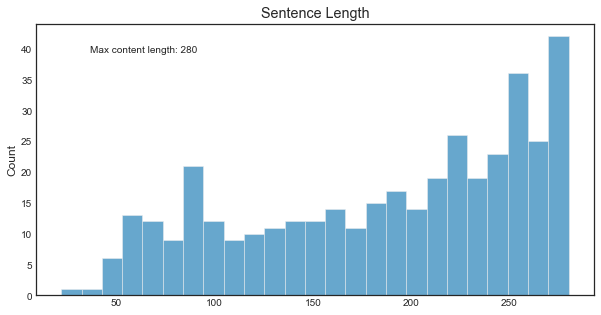

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in x_train["ContentClean"]], bins=25)
plt.title('Sentence Length')
plt.figtext(.2, .8, "Max content length: {}".format(max([len(s) for s in x_train["ContentClean"]])))
plt.style.use('ggplot') 
#plt.style.use('Solarize_Light2') 
plt.style.use('seaborn-white') 
plt.show()

In [21]:
max_tweet_len = max([len(s) for s in x_train["ContentClean"]])
max_tweet_len

280

So there are a lot of tweets that run long. I think I will pad to the max tweet length: 280.

# Setup the BERT Tokenizer and Model


In [22]:
#tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# model = BertModel.from_pretrained("distilbert-base-uncased", output_hidden_states = True)

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-uncased')

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')    # Download model and configuration from S3 and cache.

# tokenizer = None
# model = None


In [13]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

inputs = tokenizer(["Hello, my dog is cute", "Hello. Love it. Dogs are great"], padding=True, max_length=75, return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

print(inputs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0],
        [  101,  7592,  1012,  2293,  2009,  1012,  6077,  2024,  2307,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


c:\Users\r_noc\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2279: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# BERT-specific preprocessing
For the training data:
1. Tokenize the sentence
2. Add special tokens and pad
3. Create the attention mask and token ids
4. Convert the attention mask and token ids to tensors

In [23]:
# for testing, take a smaller df
my_df = x_val[0:3]
my_df

,id_stable,ContentClean,tokenIDs,mask
60,140615,Tragic news: Boy who died falling from hotel w...,,
26,26440,Sorry that may not be clear. Many of our allie...,,
378,91190,State Department Official Makes Shocking Admis...,,


# ___________ BOOKMARK - START HERE ___________

In [24]:
def bert_preprocess(df, text_col="ContentClean", tokenID_col="tokenIDs", mask_col="mask"):
    # Define: how long we want the final vectors to be, based on max (pad only), the end punctuation that we want to seperate at.
    goal_len = max([len(i) for i in df[text_col]])
    end_punct = ".!?"

    # Create two lists to hold the token ids and masks that will eventually become columns
    tokenID_list = []
    mask_list = []

    for row_idx, text in zip(df.index, df[text_col]):
        # tokenize the basic sentence
        tokens = tokenizer(text, padding=True, max_length=goal_len, return_tensors="pt") #, return_tensors='pt'
        print(tokens)

    #     # Add the CLS token to signify the beginning of the text
    #     finished_tokens = ["[CLS]"] + tokens
    #     # Add the SEP token in place of end punctuation to indicate seperations in the text
    #     for i, t in enumerate(finished_tokens):
    #         if t in end_punct:
    #             finished_tokens[i] = "[SEP]"
    #     # Make sure the final SEP token is in place
    #     if finished_tokens[-1] != "[SEP]":
    #         finished_tokens.append("[SEP]")
    #     # Find out how many PAD tokens we need to make all texts the desired length, and add them.
    #     pad_num = goal_len - len(finished_tokens)
    #     finished_tokens = finished_tokens + (pad_num * ["[PAD]"])

    #     # Create the attnetion mask, making sure PAD tokens are not given attention.
    #     attention_mask = [1 if i!= '[PAD]' else 0 for i in finished_tokens]
    #     token_ids = tokenizer.convert_tokens_to_ids(finished_tokens)

    #     # Converts token_id and attention mask to tensors
    #     token_ids = torch.tensor(token_ids).unsqueeze(0)
    #     attention_mask = torch.tensor(attention_mask).unsqueeze(0)

    #     # Add token_id and attention mask to appropriate columns
    #     # tokenID_list.append(token_ids)
    #     # mask_list.append(attention_mask)
    #     tokenID_list.append([row_idx, token_ids])
    #     mask_list.append([row_idx, attention_mask])

    # ########### START HERE ###########
    # # I need to figure out what exactly should be appended from the list to the df. 
    # # It should be something that looks kina like:
    #     # tensor([[ 101, 7078, 1996, 5409,  102, 5223, 2009,  102,    0,    0,    0]])
    #     # tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])
    # print(tokenID_list[0][1])
    # #print(mask_list[1][1])
    # # take the lists and add them as columns to the df
    # df[tokenID_col] = tokenID_list[1][1]
    # df[mask_col] = mask_list[1][1]

    # return "Yay!"

bert_preprocess(my_df, text_col="ContentClean", tokenID_col="tokenIDs", mask_col="mask")
# Thanks to "Getting Started with Google BERT"

{'input_ids': tensor([[  101, 13800,  2739,  1024,  2879,  2040,  2351,  4634,  2013,  3309,
          3332,  1999,  8533,  2001, 12632, 13141,  1010,  4311,  2360,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[  101,  3374,  2008,  2089,  2025,  2022,  3154,  1012,  2116,  1997,
          2256,  6956,  2024,  1999,  9275,  1999,  4501,  1998,  2634,  1998,
          1045,  2228,  2060,  2353,  3032,  2421, 12577,  1998, 23538,  1012,
          2035, 15497,  1996,  2345, 17397,  2000,  4875,  2000,  1996,  2866,
          1012,  2057,  1005,  2310,  2170,  2256,  3169,  2000, 25141,  9286,
         12632,  2015,  1999,  1996,  2866,  1000,  3169,  4010,  6160,  1000,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

c:\Users\r_noc\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2279: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [66]:
my_df

,id_stable,ContentClean,tokenIDs,mask
60,140615,Tragic news: Boy who died falling from hotel w...,"[[tensor(101), tensor(13800), tensor(2739), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
26,26440,Sorry that may not be clear. Many of our allie...,"[[tensor(101), tensor(3374), tensor(2008), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
378,91190,State Department Official Makes Shocking Admis...,"[[tensor(101), tensor(2110), tensor(2533), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [68]:
# Define a text, how long we want the evential padded token list to be, and what are end punctuation that we want to seperate at.
text = "Absolutely the worst. Hate it"
goal_len = 11
end_punct = ".!?"

# tokenize the basic sentence
tokens = tokenizer.tokenize(text) #, return_tensors='pt'

# Add the CLS token to signify the beginning of the text
finished_tokens = ["[CLS]"] + tokens
# Add the SEP token in place of end punctuation to indicate seperations in the text
for i, t in enumerate(finished_tokens):
    if t in end_punct:
        finished_tokens[i] = "[SEP]"
# Make sure the final SEP token is in place
if finished_tokens[-1] != "[SEP]":
    finished_tokens.append("[SEP]")
# Find out how many PAD tokens we need to make all texts the desired length, and add them.
pad_num = goal_len - len(finished_tokens)
finished_tokens = finished_tokens + (pad_num * ["[PAD]"])

# Create the attnetion mask, making sure PAD tokens are not given attention.
attention_mask = [1 if i!= '[PAD]' else 0 for i in finished_tokens]
token_ids = tokenizer.convert_tokens_to_ids(finished_tokens)

print(tokens)
print(finished_tokens)
print(attention_mask)
print(token_ids)

# Converts token_id and attention mask to tensors
token_ids = torch.tensor(token_ids).unsqueeze(0)
attention_mask = torch.tensor(attention_mask).unsqueeze(0)

print()
print(token_ids)
print(attention_mask)

# result = model(tokens)
# result
# Thanks to "Getting Started with Google BERT"

['absolutely', 'the', 'worst', '.', 'hate', 'it']
['[CLS]', 'absolutely', 'the', 'worst', '[SEP]', 'hate', 'it', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[101, 7078, 1996, 5409, 102, 5223, 2009, 102, 0, 0, 0]

tensor([[ 101, 7078, 1996, 5409,  102, 5223, 2009,  102,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])


### Get the word/token embeddings
NOTE: torch.Size([1, 7, 768]) indicates [batch_size, sequence_length, hidden_size], where 'hidden size' is the model-based representation size, 768 for BERT-base

Note: "instead of taking embeddings only from the final encoder layer (final hidden layer), we can also use embeddings from the other encoder layers," which may give better results (eg. concatenating the last four hidden). -"Getting Started with Google BERT


In [50]:
# FOR output_hidden_states = False
# hidden_rep, cls_head = model(token_ids, attention_mask = attention_mask)
# print(hidden_rep.shape) 

# FOR output_hidden_states = True
last_hidden_state, pooler_output, hidden_states = model(token_ids, attention_mask = attention_mask)
# returns: [last_hidden_state, pooler_output, hidden_states]
#   last_hidden_state[0][n]: returns the representation of the nth token in the final encoder layer
#   pooler_output: the representation of the [CLS] token, which holds the aggregate representation of the sentence.
#   hidden_states: a tuple containing 13 values holding the representation of all encoder layers (hidden layers), from the input embedding layer  to the final encoder layer 
#      hidden_states[n]: representations of all tokens from the nth encoder layer


In [51]:
rCLS = pooler_output
rCLS.shape

torch.Size([1, 768])

In [ ]:
text = "Replace me by any text you'd like."

encoded_input = tokenizer(text, return_tensors='pt')

output = model(**encoded_input)
